# Model training and hyperparameter tuning

O objetivo deste notebook é realizar testes de treino em diferentes modelos e diferentes hiperparâmetros

<u>Output</u>: Artefatos do modelo treinado

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import ks_2samp

from sklearn.metrics import (classification_report, 
                             log_loss, 
                             make_scorer, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             roc_auc_score, 
                             precision_recall_curve, 
                             roc_curve,
                             accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score
                             )

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import joblib
import datetime

In [2]:
now = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm")

## 1. Load prepare and split data

In [3]:
df = pd.read_csv('../data/train_test/full_modeling_dataset.csv', dtype = {'emissor_cartao': 'str'})

In [4]:
df.head(3)

,Valor,CBK,periodo_do_dia,dia_da_semana,emissor_cartao
0,36.54,0,madrugada,Sexta-feira,36518
1,36.54,0,madrugada,Sexta-feira,36518
2,69.00,0,madrugada,Sexta-feira,53211


In [5]:
df.dtypes

Valor             float64
CBK                 int64
periodo_do_dia     object
dia_da_semana      object
emissor_cartao     object
dtype: object

#### 1.1 Data split

In [6]:
X = df.drop(columns='CBK').copy()
y = df['CBK'].copy()

In [7]:
# Train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2


In [8]:
print(f'Train data points:{X_train.shape[0]}')
print(f'Test data points:{X_test.shape[0]}')
print(f'Validation data points:{X_val.shape[0]}')

Train data points:6602
Test data points:2201
Validation data points:2201


# 2. Model experimenting

## 2.1 Primeiro experimento: Dados desbalanceados, varios modelos

#### 2.1.1 Transformacao dos dados: Normalização e OneHotEncoding

In [9]:
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Para lgb com suporte a categ[oricas]
X_train_lgb = X_train.copy()
X_val_lgb = X_val.copy()
X_test_lgb = X_test.copy()

for col in categorical_features:
    X_train_lgb[col] = X_train_lgb[col].astype('category')
    X_val_lgb[col] = X_val_lgb[col].astype('category')
    X_test_lgb[col] = X_test_lgb[col].astype('category')

#### 2.1.2 Tuning de hiperparâmetros

##### Evaluation Utils: Plots de curva ROC, CAP, Precision-Recall e KS

In [10]:
def plot_cap(y_test, y_proba, name, ax):
    cap_df = pd.DataFrame(data=y_test, index=y_test.index)
    cap_df["Probability"] = y_proba[:,1]

    total = cap_df.iloc[:, 0].sum()
    perfect_model = (cap_df.iloc[:, 0].sort_values(ascending=False).cumsum()/total).values
    current_model = (cap_df.sort_values(by="Probability", ascending=False).iloc[:, 0].cumsum()/total).values

    max_area = 0
    covered_area = 0
    h = 1/len(perfect_model)
    random = np.linspace(0, 1, len(perfect_model))
    for i, (am, ap) in enumerate(zip(current_model, perfect_model)):
        try:
            max_area += (ap-random[i]+perfect_model[i+1]-random[i+1])*h/2
            covered_area += (am-random[i]+current_model[i+1]-random[i+1])*h/2
        except:
            continue
    accuracy_ratio = covered_area/max_area

    ax.plot(np.linspace(0, 1, len(current_model)), current_model, 
                        color="green", label=f"{name}: AR = {accuracy_ratio:.3f}")
    ax.plot(np.linspace(0, 1, len(perfect_model)), perfect_model, color="red", label="Perfect Model")
    ax.plot([0,1], [0,1], color="navy")
    ax.set_xlabel("Individuals", fontsize=12)
    ax.set_ylabel("Target Individuals", fontsize=12)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1.01))
    ax.legend(loc=4, fontsize=10)
    ax.set_title("CAP Analysis", fontsize=13)

def plot_roc(y_test, y_proba, name, ax):
    fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
    
    ax.plot(fpr, tpr, color="red", label=f"{name} (AUC = {roc_auc_score(y_test, y_proba[:,1]):.3f})")
    ax.plot([0,1], [0,1], color="navy")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim((0,1))
    ax.set_ylim((0,1.001))
    ax.legend(loc=4)
    ax.set_title("ROC Analysis", fontsize=13)

def plot_pr(y_test, y_proba, name, ax):
    precision, recall, _ = precision_recall_curve(y_test, y_proba[:,1])
    
    ax.plot(recall, precision, color="red", label=f"{name}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim((0,1))
    ax.set_ylim((0,1.001))
    ax.legend(loc=4)
    ax.set_title("Precision-Recall Analysis", fontsize=13)


def plot_ks(y_test, y_proba, name, ax):
    prediction_labels = pd.DataFrame(y_test.values, columns=["True Label"])
    prediction_labels["Probabilities"] = y_proba[:,1]
    prediction_labels["Thresholds"] = prediction_labels["Probabilities"].apply(lambda x: np.round(x, 2))
    df = prediction_labels.groupby("Thresholds").agg(["count", "sum"])[["True Label"]]
    ks_df = pd.DataFrame(df["True Label"]["sum"]).rename(columns={"sum":"Negative"})
    ks_df["Positive"] = df["True Label"]["count"]-df["True Label"]["sum"]
    ks_df["Negative"] = ks_df["Negative"].cumsum()/ks_df["Negative"].sum()
    ks_df["Positive"] = ks_df["Positive"].cumsum()/ks_df["Positive"].sum()
    ks_df["KS"] = ks_df["Positive"]-ks_df["Negative"]
    ks_df.loc[0.0, :] = [0.0, 0.0, 0.0]
    ks_df = ks_df.sort_index()
    max_ks_thresh = ks_df.KS.idxmax()

    ks_df.loc[:, "Negative"].plot(color="navy", ax=ax)
    ks_df.loc[:, "Positive"].plot(color="red", ax=ax)
    ax.set_title("KS Analysis", fontsize=13)
    ax.plot([max_ks_thresh, max_ks_thresh], 
            [ks_df.loc[max_ks_thresh,"Negative"], ks_df.loc[max_ks_thresh,"Positive"]], color="green", label="Max KS")
    ax.text(max_ks_thresh-0.15, 0.5, f"KS={ks_df.loc[max_ks_thresh,'KS']:.3f}", fontsize=12, color="green")
    ax.legend()


def ks_stat(y_true, y_pred):
    return ks_2samp(y_pred[y_true==1], y_pred[y_true!=1]).statistic

def get_scorer(metric):
    if metric=="Accuracy":
        return accuracy_score
    elif metric=="Precision":
        return precision_score
    elif metric=="Recall":
        return recall_score
    elif metric=="F1-Score":
        return f1_score
    elif metric=="AUC-ROC":
        return roc_auc_score
    elif metric=="KS":
        return ks_stat
    else:
        raise ValueError(f"Métrica não disponível!\nEscolha uma das seguintes métrics: {METRICS}")

def evaluate(y_true, y_pred, y_score, METRICS, model_name=''):
    metrics = {}
    for metric in METRICS:
        if metric=="auc_roc":
            metrics[metric] = np.round(100*get_scorer(metric)(y_true, y_score), 2)
        else:
            metrics[metric] = np.round(100*get_scorer(metric)(y_true, y_pred), 2)

    return pd.DataFrame(metrics, index=[model_name])

In [11]:
def evaluate_binary(y_true, y_score, name):
    fig, ax = plt.subplots(2,2,figsize=(13, 9))
    plot_roc(y_true, y_score, name, ax[0][0])
    plot_pr(y_true, y_score, name, ax[0][1])
    plot_cap(y_true, y_score, name, ax[1][0])
    plot_ks(y_true, y_score, name, ax[1][1])
    plt.tight_layout()
    plt.show()

##### Tuning

In [12]:
param_grid_lr = {'C': [0.1, 1, 10]}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 9]}
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grid_xgb = {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 9], 'learning_rate': [0.01, 0.1, 0.2]}

param_grids = {
    'Logistic Regression': (LogisticRegression(), param_grid_lr),
    'Random Forest': (RandomForestClassifier(), param_grid_rf),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb),
}

LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
best_models = {}
for name, (model, param_grid) in param_grids.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=LogLoss)
    grid_search.fit(X_train_transformed, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"{name} best params: {grid_search.best_params_}")

d:\Github Repos\missao-data-science-stoneco\.venv\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Logistic Regression best params: {'C': 10}
Random Forest best params: {'max_depth': 9, 'n_estimators': 100}
XGBoost best params: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100}


In [13]:
for name, model in best_models.items():
    y_pred = model.predict(X_val_transformed)
    report = classification_report(y_val, y_pred)
    print(f"{name}")
    print(report)
    print('-----------------------------------------------------')

Logistic Regression
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2092
           1       0.54      0.23      0.32       109

    accuracy                           0.95      2201
   macro avg       0.75      0.61      0.65      2201
weighted avg       0.94      0.95      0.94      2201

-----------------------------------------------------
Random Forest
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2092
           1       0.00      0.00      0.00       109

    accuracy                           0.95      2201
   macro avg       0.48      0.50      0.49      2201
weighted avg       0.90      0.95      0.93      2201

-----------------------------------------------------
XGBoost
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2092
           1       0.78      0.41      0.54       109

    accuracy                    

d:\Github Repos\missao-data-science-stoneco\.venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Github Repos\missao-data-science-stoneco\.venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Github Repos\missao-data-science-stoneco\.venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [14]:
param_grid_lgb = {
    'n_estimators': [50, 100, 200],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}

grid_search_lgb = GridSearchCV(LGBMClassifier(verbosity=-1), param_grid_lgb, cv=5, scoring=LogLoss)
grid_search_lgb.fit(X_train_lgb, y_train, categorical_feature=categorical_features)
best_model_lgb = grid_search_lgb.best_estimator_

grid_search_lgb.best_params_

{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50, 'num_leaves': 50}

In [15]:
y_pred_lgb = best_model_lgb.predict(X_val_lgb)
report = classification_report(y_val, y_pred_lgb)
print(f"LGB Classifier")
print(report)

LGB Classifier
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2092
           1       0.71      0.57      0.63       109

    accuracy                           0.97      2201
   macro avg       0.85      0.78      0.81      2201
weighted avg       0.96      0.97      0.97      2201



In [16]:
param_grid_lgb = {
    'n_estimators': [25, 50, 75],
    'num_leaves': [40, 50, 60],
    'learning_rate': [0.2, 0.25, 0.3],
    'max_depth': [5, 6, 7]
}

# Perform grid search with cross-validation
grid_search_lgb2 = GridSearchCV(LGBMClassifier(verbosity=-1), param_grid_lgb, cv=5, scoring=LogLoss)
grid_search_lgb2.fit(X_train_lgb, y_train, categorical_feature=categorical_features)
best_model_lgb2 = grid_search_lgb2.best_estimator_

grid_search_lgb2.best_params_

{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50, 'num_leaves': 50}

In [17]:
best_model_lgb2

LGBMClassifier(learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=50,
               verbosity=-1)

In [18]:
y_pred_lgb = best_model_lgb2.predict(X_val_lgb)
report = classification_report(y_val, y_pred_lgb)
print(f"LGB Classifier")
print(report)

LGB Classifier
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2092
           1       0.71      0.57      0.63       109

    accuracy                           0.97      2201
   macro avg       0.85      0.78      0.81      2201
weighted avg       0.96      0.97      0.97      2201



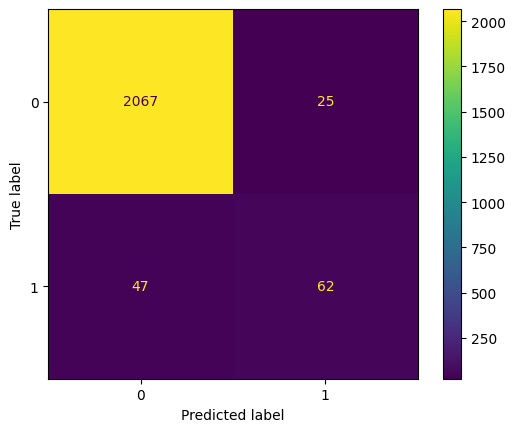

In [19]:
cm = confusion_matrix(y_val, y_pred_lgb, labels=best_model_lgb2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

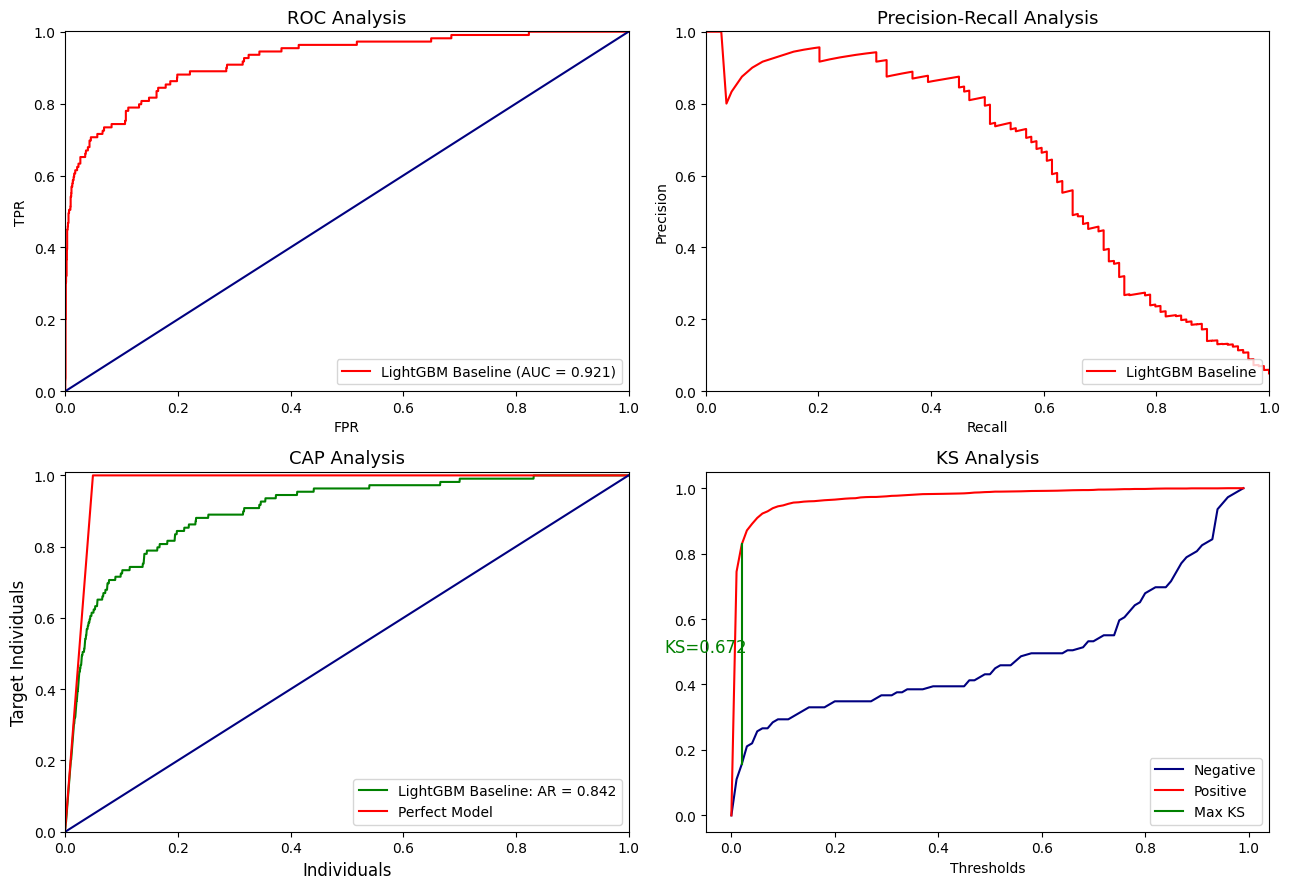

In [20]:
name="LightGBM Baseline"
pred_prob = best_model_lgb2.predict_proba(X_val_lgb)
evaluate_binary(y_val,pred_prob,name)

**Explicando as curvas**:
<u>ROC AUC</u>: Em termos simples significa a capacidade do modelo ou sua 'confiança' em separar a classe negativa da classe positiva. Quanto maior o valor, melhor o modelo consegue determinar os exemplos positivos acima dos negativos. A curva em azul representa um ROC AUC de 0,5 que significa que o modelo não tem poder preditivo (como se previsse aleatóriamente como um jogar de moedas)

<u>CAP Analysis</u>: Ou Cumulative Accuracy Profile tenta mostrar a 'velocidade' ou performance do modelo em classificar todos os dados usando um número mínimo de tentativas

<u>KS Analysis</u>: Ou teste de Komolgorov-Smirnov capta a maior distância entre as curvas de probabilidade da classe positiva e da classe negativa. A intuição é simples: "se um modelo atribui menores pontuações de probabilidade para a classe negativa e maiores pontuações de probabilidade para a classe positiva, podemos dizer que este é um bom modelo"(TREVISAN,Vinicius)

<u>Precision-recall</u>: A curva precision-recall mostra o relacionamento entre acertos do modelo e a sensibilidade ou nível de incerteza para cada ponto de corte entre as classes.*

Fontes: 
- https://towardsdatascience.com/machine-learning-classifier-evaluation-using-roc-and-cap-curves-7db60fe6b716
- https://towardsdatascience.com/evaluating-classification-models-with-kolmogorov-smirnov-ks-test-e211025f5573

* Cálculo do ponto de corte ótimo do modelo: 

In [21]:
def optimal_proba_cutoff(y_test, y_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    opt_prob_cutoff = sorted(list(zip(np.abs(tpr - fpr), thresholds)), key=lambda i: i[0], reverse=True)[0][1]
    return opt_prob_cutoff

In [22]:
lgb2_pred_prob_test = best_model_lgb2.predict_proba(X_test_lgb)[:,1]
opt_prob_cutoff_test = optimal_proba_cutoff(y_test, lgb2_pred_prob_test)
print(f"Optimal probabilities cutoff: {opt_prob_cutoff_test}")

lgb2_pred_class_test = (lgb2_pred_prob_test >= opt_prob_cutoff_test).astype(int)
print(classification_report(y_test, lgb2_pred_class_test))

Optimal probabilities cutoff: 0.031235865277453433
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      2096
           1       0.23      0.84      0.37       105

    accuracy                           0.86      2201
   macro avg       0.61      0.85      0.64      2201
weighted avg       0.95      0.86      0.90      2201



In [41]:
y_test.value_counts()

CBK
0    2096
1     105
Name: count, dtype: int64

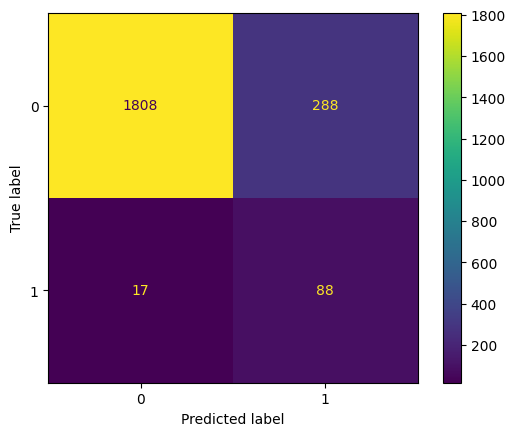

In [23]:
cm_opt = confusion_matrix(y_test, lgb2_pred_class_test, labels=best_model_lgb2.classes_)
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt)
disp_opt.plot()

## 2.2 Segundo experimento: Dados balanceados, lightgbm

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [25]:
X_full_transformed = preprocessor.transform(X)

In [26]:
print("Distribuição original de do target:", Counter(y))

# SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_full_transformed, y)

# RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.2, random_state=42)
X_resampled_under, y_resampled_under = undersample.fit_resample(X_full_transformed, y)

# Class distribution after resampling
print("Distribuição do target pós SMOTE:", Counter(y_resampled_smote))
print("Distribuição do target pós RandomUnderSampler:", Counter(y_resampled_under))

Distribuição original de do target: Counter({0: 10436, 1: 568})
Distribuição do target pós SMOTE: Counter({0: 10436, 1: 10436})
Distribuição do target pós RandomUnderSampler: Counter({0: 2840, 1: 568})


In [27]:
# Split em apenas em treino e teste para não perder muitos pontos além dos removidos após balanceamento, usando o randomundersampler

X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_resampled_under, y_resampled_under, test_size=0.33, random_state=42)

In [28]:
param_grid_lgb = {
    'n_estimators': [25, 50, 75],
    'num_leaves': [40, 50, 60],
    'learning_rate': [0.2, 0.25, 0.3],
    'max_depth': [5, 6, 7]
}

# Perform grid search with cross-validation
grid_search_rus = GridSearchCV(LGBMClassifier(verbosity=-1), param_grid_lgb, cv=5, scoring=LogLoss)
grid_search_rus.fit(X_train_rus, y_train_rus)
best_model_rus = grid_search_rus.best_estimator_

grid_search_rus.best_params_

{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 75, 'num_leaves': 40}

In [29]:
y_pred_lgb_rus = best_model_rus.predict(X_test_transformed)
report = classification_report(y_test, y_pred_lgb_rus)
print(f"LGB Classifier")
print(report)

LGB Classifier
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2096
           1       0.45      0.54      0.49       105

    accuracy                           0.95      2201
   macro avg       0.71      0.75      0.73      2201
weighted avg       0.95      0.95      0.95      2201



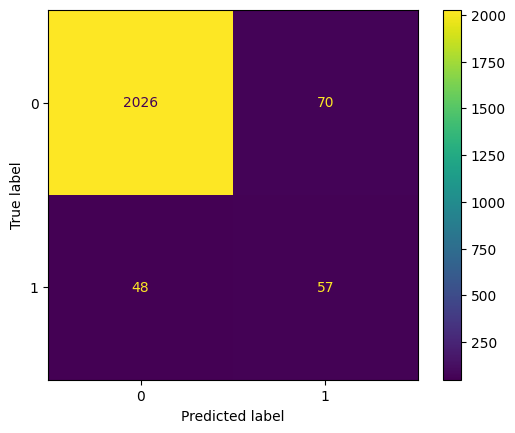

In [30]:
cm = confusion_matrix(y_test, y_pred_lgb_rus, labels=best_model_rus.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Nota: Verificação feita nos dados de testes originais para ver se o modelo conseguia generalizar bem em dados reais sendo treinado com amostragem

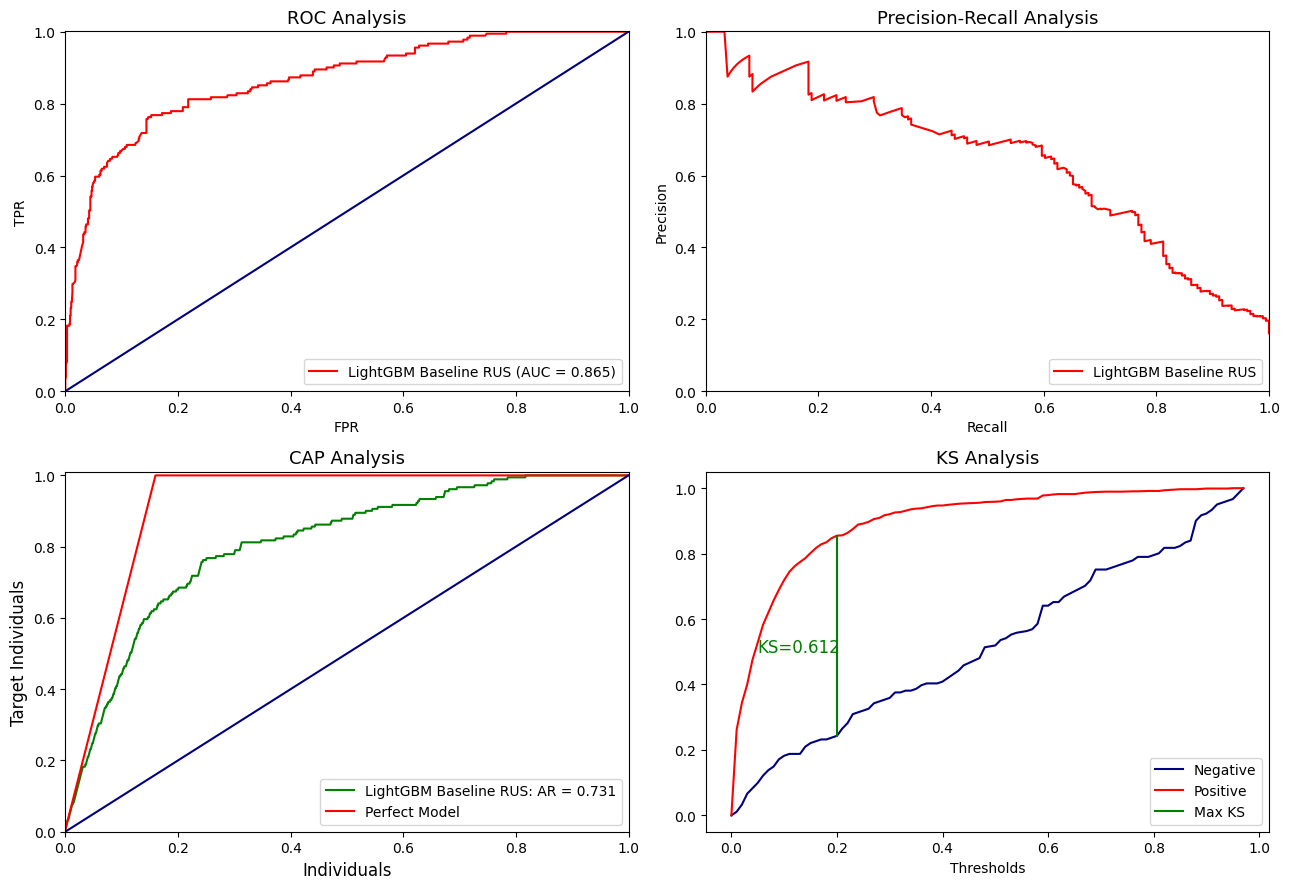

In [31]:
name="LightGBM Baseline RUS"
pred_prob_rus = best_model_rus.predict_proba(X_test_rus)
evaluate_binary(y_test_rus,pred_prob_rus,name)

# 3. Resultados finais

Como o modelo usando RandomUnderSampler não se mostrou mais eficiente em separar as classes e melhor recall, opta-se por prosseguir com o modelo treinado nos dados sem estratégia de balanceamento.

Os resultados em teste para o modelo selecionado são:

In [32]:
print(classification_report(y_test, lgb2_pred_class_test))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      2096
           1       0.23      0.84      0.37       105

    accuracy                           0.86      2201
   macro avg       0.61      0.85      0.64      2201
weighted avg       0.95      0.86      0.90      2201



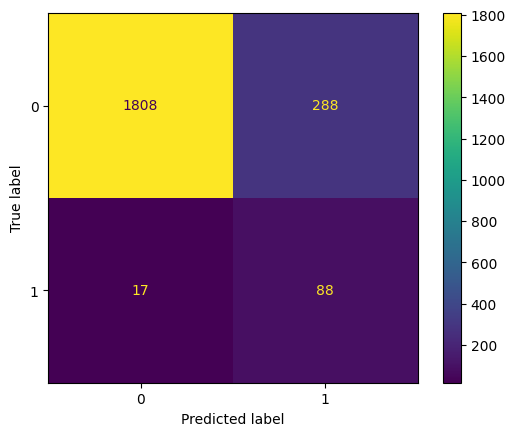

In [33]:
disp_opt.plot()

# 4. Versionamento dos artefatos

In [34]:
import joblib

In [40]:
# Modelo
model_version_path = f'../models/model_{now}.pkl'
joblib.dump(best_model_lgb2, model_version_path)

# Dados
train = pd.concat([X_train_lgb, y_train], axis=1)
val =  pd.concat([X_val_lgb, y_val], axis=1)
test = pd.concat([X_test_lgb, y_test], axis=1)

train.to_csv(f'../data/train_test/train_{now}.csv', index=False)
val.to_csv(f'../data/train_test/val_{now}.csv', index=False)
test.to_csv(f'../data/train_test/test_{now}.csv', index=False)

# Resultados
METRICS = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC", "KS"]
model_results = evaluate(y_test, lgb2_pred_class_test, lgb2_pred_prob_test, METRICS=METRICS, model_name=f'Lightgbm_{now}')
model_results['opt_prob_cutoff'] = opt_prob_cutoff_test
model_results.to_csv(f'../models/results_model_{now}.csv', index=False)
model_results

,Accuracy,Precision,Recall,F1-Score,AUC-ROC,KS,opt_prob_cutoff
Lightgbm_2024-06-10_13h34m,86.14,23.4,83.81,36.59,85.03,70.07,0.031236
